# CROMD – Formulação Baseada em Fluxo (CPLEX)

Implementação do modelo em `cplex` conforme a formulação de fluxo.

In [8]:
import time
from typing import Dict, Any

import cplex
from cplex import SparsePair


In [9]:
def _compute_coverers(N_list, Viz):
    n_set = set(N_list)
    coverers = {i: set() for i in N_list}
    for j in N_list:
        cov_plus = set(Viz[j]) if j < len(Viz) else set()
        cov_plus.add(j)
        if 0 in cov_plus:
            cov_plus.discard(0)
        for i in cov_plus:
            if i in n_set:
                coverers[i].add(j)
    return {i: sorted(coverers[i]) for i in N_list}

def build_cromd_flow_model(V, N, A, d, C, K, Viz):
    V_list = list(V)
    N_list = list(N)
    A_list = list(A)
    drone_ids = list(range(K))

    assert 0 in V_list, "Base 0 must be in V"
    assert 0 not in N_list, "Base 0 must not be in N"

    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)

    var_index: Dict[str, Any] = {}

    coverers = _compute_coverers(N_list, Viz)
    var_index["coverers"] = coverers

    def add_block(names, types, lb=None, ub=None, obj=None):
        if lb is None:
            lb = [0.0] * len(names)
        if ub is None:
            ub = [cplex.infinity] * len(names)
        if obj is None:
            obj = [0.0] * len(names)
        start = cpx.variables.get_num()
        cpx.variables.add(names=names, types=types, lb=lb, ub=ub, obj=obj)
        return list(range(start, start + len(names)))

    # T
    t_indices = add_block(["T"], ["C"], lb=[0.0], ub=[cplex.infinity], obj=[1.0])
    var_index["T"] = t_indices[0]

    # u
    u_names = [f"u_{k}" for k in drone_ids]
    u_indices = add_block(u_names, ["B"] * len(u_names), lb=[0.0] * len(u_names), ub=[1.0] * len(u_names))
    u_index = {k: idx for k, idx in zip(drone_ids, u_indices)}
    var_index["u"] = u_index
    var_index["u_indices"] = u_indices

    # y
    y_names = [f"y_{k}_{i}" for k in drone_ids for i in N_list]
    y_indices = add_block(y_names, ["B"] * len(y_names), lb=[0.0] * len(y_names), ub=[1.0] * len(y_names))
    y_index = {}
    y_idx_by_k = {}
    pos = 0
    for k in drone_ids:
        y_idx_by_k[k] = y_indices[pos:pos + len(N_list)]
        for i, idx in zip(N_list, y_idx_by_k[k]):
            y_index[(k, i)] = idx
        pos += len(N_list)
    var_index["y"] = y_index
    var_index["y_indices"] = y_indices
    var_index["y_keys"] = [(k, i) for k in drone_ids for i in N_list]

    # x
    x_names = [f"x_{k}_{i}_{j}" for k in drone_ids for (i, j) in A_list]
    x_indices = add_block(x_names, ["B"] * len(x_names), lb=[0.0] * len(x_names), ub=[1.0] * len(x_names))
    x_index = {}
    x_idx_by_k = {}
    pos = 0
    for k in drone_ids:
        x_idx_by_k[k] = x_indices[pos:pos + len(A_list)]
        for (i, j), idx in zip(A_list, x_idx_by_k[k]):
            x_index[(k, i, j)] = idx
        pos += len(A_list)
    var_index["x"] = x_index
    var_index["x_indices"] = x_indices
    var_index["x_keys"] = [(k, i, j) for k in drone_ids for (i, j) in A_list]
    var_index["x_idx_by_k"] = x_idx_by_k

    # z
    z_names = [f"z_{k}_{i}_{j}" for k in drone_ids for (i, j) in A_list]
    z_indices = add_block(z_names, ["I"] * len(z_names), lb=[0.0] * len(z_names))
    z_index = {}
    z_idx_by_k = {}
    pos = 0
    for k in drone_ids:
        z_idx_by_k[k] = z_indices[pos:pos + len(A_list)]
        for (i, j), idx in zip(A_list, z_idx_by_k[k]):
            z_index[(k, i, j)] = idx
        pos += len(A_list)
    var_index["z"] = z_index
    var_index["z_indices"] = z_indices
    var_index["z_keys"] = [(k, i, j) for k in drone_ids for (i, j) in A_list]

    d_vals = [d[(i, j)] for (i, j) in A_list]

    # 1) Makespan
    lin_expr = []
    senses = []
    rhs = []
    for k in drone_ids:
        indices = x_idx_by_k[k] + [var_index["T"]]
        values = d_vals + [-1.0]
        lin_expr.append(SparsePair(ind=indices, val=values))
        senses.append("L")
        rhs.append(0.0)
    cpx.linear_constraints.add(lin_expr=lin_expr, senses=senses, rhs=rhs)

    # 2) Autonomia
    lin_expr = []
    senses = []
    rhs = []
    for k in drone_ids:
        lin_expr.append(SparsePair(ind=x_idx_by_k[k], val=d_vals))
        senses.append("L")
        rhs.append(C)
    cpx.linear_constraints.add(lin_expr=lin_expr, senses=senses, rhs=rhs)

    # 3) Saida e retorno a base
    lin_expr = []
    senses = []
    rhs = []
    for k in drone_ids:
        out_indices = [x_index[(k, 0, j)] for j in N_list]
        in_indices = [x_index[(k, j, 0)] for j in N_list]
        lin_expr.append(SparsePair(ind=out_indices + [u_index[k]], val=[1.0] * len(out_indices) + [-1.0]))
        senses.append("E")
        rhs.append(0.0)
        lin_expr.append(SparsePair(ind=in_indices + [u_index[k]], val=[1.0] * len(in_indices) + [-1.0]))
        senses.append("E")
        rhs.append(0.0)
    cpx.linear_constraints.add(lin_expr=lin_expr, senses=senses, rhs=rhs)

    # 4) Grau nos sensores visitados
    lin_expr = []
    senses = []
    rhs = []
    for k in drone_ids:
        for i in N_list:
            out_indices = [x_index[(k, i, j)] for j in V_list if j != i]
            in_indices = [x_index[(k, j, i)] for j in V_list if j != i]
            lin_expr.append(SparsePair(ind=out_indices + [y_index[(k, i)]], val=[1.0] * len(out_indices) + [-1.0]))
            senses.append("E")
            rhs.append(0.0)
            lin_expr.append(SparsePair(ind=in_indices + [y_index[(k, i)]], val=[1.0] * len(in_indices) + [-1.0]))
            senses.append("E")
            rhs.append(0.0)
    cpx.linear_constraints.add(lin_expr=lin_expr, senses=senses, rhs=rhs)

    # 5) Ativacao do drone
    lin_expr = []
    senses = []
    rhs = []
    for k in drone_ids:
        for i in N_list:
            lin_expr.append(SparsePair(ind=[y_index[(k, i)], u_index[k]], val=[1.0, -1.0]))
            senses.append("L")
            rhs.append(0.0)
    cpx.linear_constraints.add(lin_expr=lin_expr, senses=senses, rhs=rhs)

    # 6) Simetria do drone
    lin_expr = []
    senses = []
    rhs = []
    for k in range(K - 1):
        lin_expr.append(SparsePair(ind=[u_index[k + 1], u_index[k]], val=[1.0, -1.0]))
        senses.append("L")
        rhs.append(0.0)
        indices = x_idx_by_k[k + 1] + x_idx_by_k[k]
        values = d_vals + [-v for v in d_vals]
        lin_expr.append(SparsePair(ind=indices, val=values))
        senses.append("L")
        rhs.append(0.0)
    if lin_expr:
        cpx.linear_constraints.add(lin_expr=lin_expr, senses=senses, rhs=rhs)

    # 7) Cobertura
    lin_expr = []
    senses = []
    rhs = []
    for i in N_list:
        cover_nodes = coverers[i]
        indices = [y_index[(k, j)] for k in drone_ids for j in cover_nodes]
        lin_expr.append(SparsePair(ind=indices, val=[1.0] * len(indices)))
        senses.append("G")
        rhs.append(1.0)
    cpx.linear_constraints.add(lin_expr=lin_expr, senses=senses, rhs=rhs)

    # 8) Visita unica
    lin_expr = []
    senses = []
    rhs = []
    for i in N_list:
        indices = [y_index[(k, i)] for k in drone_ids]
        lin_expr.append(SparsePair(ind=indices, val=[1.0] * len(indices)))
        senses.append("L")
        rhs.append(1.0)
    cpx.linear_constraints.add(lin_expr=lin_expr, senses=senses, rhs=rhs)

    # 9) Fluxo - conservacao
    lin_expr = []
    senses = []
    rhs = []
    for k in drone_ids:
        for i in N_list:
            in_indices = [z_index[(k, j, i)] for j in V_list if j != i]
            out_indices = [z_index[(k, i, j)] for j in V_list if j != i]
            indices = in_indices + out_indices + [y_index[(k, i)]]
            values = [1.0] * len(in_indices) + [-1.0] * len(out_indices) + [-1.0]
            lin_expr.append(SparsePair(ind=indices, val=values))
            senses.append("E")
            rhs.append(0.0)
    cpx.linear_constraints.add(lin_expr=lin_expr, senses=senses, rhs=rhs)

    # 9) Fluxo - fonte na base
    lin_expr = []
    senses = []
    rhs = []
    for k in drone_ids:
        out_indices = [z_index[(k, 0, j)] for j in N_list]
        in_indices = [z_index[(k, j, 0)] for j in N_list]
        y_indices_k = [y_index[(k, i)] for i in N_list]
        indices = out_indices + in_indices + y_indices_k
        values = [1.0] * len(out_indices) + [-1.0] * len(in_indices) + [-1.0] * len(y_indices_k)
        lin_expr.append(SparsePair(ind=indices, val=values))
        senses.append("E")
        rhs.append(0.0)
    cpx.linear_constraints.add(lin_expr=lin_expr, senses=senses, rhs=rhs)

    # 9) Fluxo - acoplamento
    lin_expr = []
    senses = []
    rhs = []
    big_m = float(len(N_list))
    for k in drone_ids:
        for (i, j) in A_list:
            lin_expr.append(SparsePair(ind=[z_index[(k, i, j)], x_index[(k, i, j)]], val=[1.0, -big_m]))
            senses.append("L")
            rhs.append(0.0)
    cpx.linear_constraints.add(lin_expr=lin_expr, senses=senses, rhs=rhs)

    return cpx, var_index


In [10]:
def solve_cromd_flow_cplex(V, N, A, d, C, K, Viz, timelimit, mipgap=None, threads=None, seed=None):
    start_time = time.time()
    N_list = list(N)
    coverers = _compute_coverers(N_list, Viz)
    empty_coverers = [i for i in N_list if not coverers[i]]
    if empty_coverers:
        runtime_sec = time.time() - start_time
        result = {
            "status": None,
            "status_string": f"infeasible_coverers: {empty_coverers}",
            "objective_T": None,
            "makespan": None,
            "used_drones": [],
            "routes": [],
            "x_values": None,
            "runtime_sec": runtime_sec,
        }
        print(result["status_string"])
        return result
    cpx, var_index = build_cromd_flow_model(V, N, A, d, C, K, Viz)

    if timelimit is not None:
        cpx.parameters.timelimit.set(timelimit)
    if mipgap is not None:
        cpx.parameters.mip.tolerances.mipgap.set(mipgap)
    if threads is not None:
        cpx.parameters.threads.set(threads)
    if seed is not None:
        cpx.parameters.randomseed.set(seed)

    cpx.solve()
    runtime_sec = time.time() - start_time

    status_code = cpx.solution.get_status()
    status_string = cpx.solution.get_status_string()
    result = {
        "status": status_code,
        "status_string": status_string,
        "objective_T": None,
        "makespan": None,
        "used_drones": [],
        "routes": [],
        "x_values": None,
        "runtime_sec": runtime_sec,
    }

    print(f"Vars: {cpx.variables.get_num()}, Cons: {cpx.linear_constraints.get_num()}")
    print(f"Timelimit: {timelimit}, Status: {status_string}")

    if not cpx.solution.is_primal_feasible():
        return result

    V_list = list(V)
    N_list = list(N)
    drone_ids = list(range(K))
    tol = 1e-6

    T_val = cpx.solution.get_values(var_index["T"])
    result["objective_T"] = T_val
    result["makespan"] = T_val

    u_vals = cpx.solution.get_values(var_index["u_indices"])
    used_drones = [k for k, val in zip(drone_ids, u_vals) if val > 0.5]
    result["used_drones"] = used_drones

    x_vals = cpx.solution.get_values(var_index["x_indices"])
    y_vals = cpx.solution.get_values(var_index["y_indices"])

    x_keys = var_index["x_keys"]
    y_keys = var_index["y_keys"]

    x_map = dict(zip(x_keys, x_vals))
    y_map = dict(zip(y_keys, y_vals))

    result["x_values"] = x_map

    # Rotas
    routes = []
    for k in used_drones:
        outs = {i: [] for i in V_list}
        for (kk, i, j), val in x_map.items():
            if kk != k:
                continue
            if val > 0.5:
                outs[i].append(j)
        route = [0]
        current = 0
        for _ in range(len(V_list) + 1):
            if not outs[current]:
                break
            nxt = outs[current][0]
            route.append(nxt)
            current = nxt
            if current == 0:
                break
        routes.append(route)
    result["routes"] = routes

    print(f"T: {T_val}, Used drones: {len(used_drones)}")

    # Validacoes se solucao inteira
    def is_integral(values):
        return all(abs(v - round(v)) <= tol for v in values)

    if is_integral(u_vals) and is_integral(y_vals) and is_integral(x_vals):
        # Cobertura
        for i in N_list:
            cover_nodes = coverers[i]
            covered = False
            for k in drone_ids:
                for j in cover_nodes:
                    if y_map.get((k, j), 0.0) > 0.5:
                        covered = True
                        break
                if covered:
                    break
            assert covered, f"Sensor {i} sem cobertura"

        # Rotas e capacidade
        makespan = 0.0
        for k in used_drones:
            out_count = {i: 0 for i in V_list}
            in_count = {i: 0 for i in V_list}
            for (kk, i, j), val in x_map.items():
                if kk != k or val <= 0.5:
                    continue
                out_count[i] += 1
                in_count[j] += 1

            assert out_count[0] == 1 and in_count[0] == 1, "Base deve ter grau 1 se u=1"
            for i in N_list:
                if y_map.get((k, i), 0.0) > 0.5:
                    assert out_count[i] == 1 and in_count[i] == 1, f"Grau invalido no sensor {i}"

            # Distancia da rota
            route = routes[used_drones.index(k)]
            assert route[0] == 0 and route[-1] == 0, "Rota deve iniciar e terminar em 0"
            dist = 0.0
            for a, b in zip(route[:-1], route[1:]):
                dist += d[(a, b)]
            assert dist <= C + 1e-5, f"Capacidade violada: {dist} > {C}"
            makespan = max(makespan, dist)

        assert abs(makespan - T_val) <= 1e-4, "Makespan diferente de T"

    return result


In [ ]:
import instance_utils

# path = "../data/instances/instancia1Tijuca.csv"
path = "../data/toy_instances/toy_2d_25_1-5.csv"
data = instance_utils.read_instance(path, distance_type='euclidean')

V, N, A, d, C, K, Viz = data['V'], data['N'], data['A'], data['d'], data['C'], data['K'], data['Viz']

result = solve_cromd_flow_cplex(V, N, A, d, C, K, Viz, timelimit=300, mipgap=None, threads=None, seed=None)


Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               300
Tried aggregator 1 time.
MIP Presolve eliminated 14 rows and 0 columns.
Reduced MIP has 8468 rows, 14701 columns, and 73534 nonzeros.
Reduced MIP has 7500 binaries, 7200 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (36.37 ticks)
Probing fixed 1 vars, tightened 0 bounds.
Probing time = 0.04 sec. (35.83 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 25 rows and 1 columns.
MIP Presolve modified 144 coefficients.
Reduced MIP has 8443 rows, 14700 columns, and 73470 nonzeros.
Reduced MIP has 7499 binaries, 7200 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.04 sec. (65.27 ticks)
Probing time = 0.01 sec. (11.97 ticks)
Clique table members: 44476.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads

In [15]:
instance_utils.print_solution(data, result)

======== Instância ========
Número de sensores (|V|): 25
Número de drones (K): 12
Capacidade dos drones (C): 11.3137


==== Resultado da Solucao ====
Status: time limit exceeded
Makespan (T): 8.4853
Drones usados: 4
  Rota drone 0: [0, 12, 18, 0] (dist=8.4853)
  Rota drone 1: [0, 3, 0] (dist=6.0000)
  Rota drone 2: [0, 15, 0] (dist=6.0000)
  Rota drone 3: [0, 1, 6, 5, 0] (dist=4.0000)
Tempo de execucao (s): 300.06


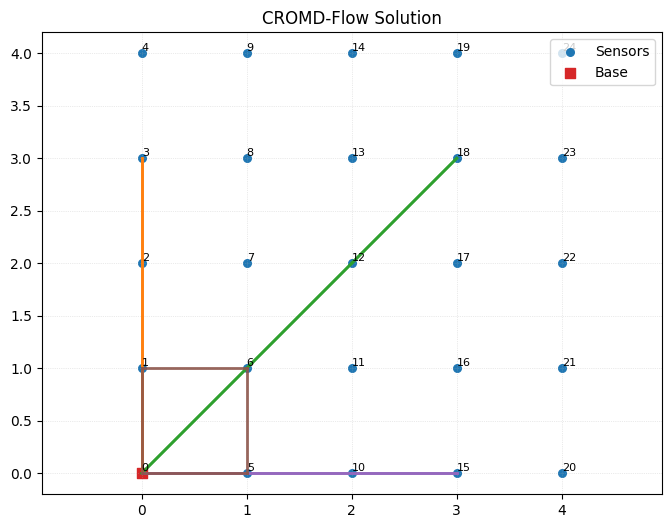

In [14]:
instance_utils.plot_instance_routes(data, result, show_coverage=False, title="CROMD-Flow Solution")